## Distance calculation
This code implements an emotion analysis system using word embeddings and a pre-defined emotion lexicon. The EmotionDistanceCalculator class calculates the emotional similarity between input words and words in an emotion lexicon by computing cosine similarities between their embeddings (generated using DistilBERT). It includes features for similarity score calibration, batch processing, and caching of word embeddings. The system can map words to eight distinct emotions (anger, anticipation, disgust, fear, joy, sadness, surprise, trust) plus neutral, using various calibration methods (exponential, sigmoid, power, minmax) to adjust similarity scores.


In [6]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from tqdm import tqdm
from transformers import pipeline
from sklearn.mixture import GaussianMixture
%matplotlib inline

def _compute_similarity(emb1, emb2):
    """Safely compute cosine similarity between two embeddings."""
    try:
        # Ensure vectors are 1D
        emb1 = emb1.flatten()
        emb2 = emb2.flatten()
        return 1 - cosine(emb1, emb2)
    except Exception as e:
        print(f"Error computing similarity: {e}")
        return 0.0


def create_emotion_vectors(calculator):
    """Create binary emotion vectors for each word in the lexicon."""
    all_emotions = calculator.emotions
    emotion_vectors = {}

    for word, emotions in calculator.emotion_lexicon.items():
        # Create binary vector
        vector = np.zeros(len(all_emotions))
        for emotion in emotions:
            if emotion in all_emotions:
                idx = all_emotions.index(emotion)
                vector[idx] = 1
        emotion_vectors[word] = vector

    return emotion_vectors


class EmotionDistanceCalculator:
    def __init__(self, emotion_lexicon, device="mps", min_similarity=0,
                 batch_size=32, calibration_method='exponential',
                 temperature=10.0, use_clusters=False):
        self.normilize_clusters = True
        self.use_clusters = use_clusters
        self.emotion_lexicon = emotion_lexicon
        self.device = device
        self.min_similarity = min_similarity
        self.batch_size = batch_size
        self.calibration_method = calibration_method
        self.temperature = temperature
        self.emotions = ['anger', 'anticipation', 'disgust', 'fear',
                         'joy', 'sadness', 'surprise', 'trust', 'neutral']

        self._normalize_lexicon()
        self.embedder = pipeline("feature-extraction",
                                 model="distilbert-base-uncased",
                                 device=device)
        self.word_embeddings = {}
        self._cache_lexicon_embeddings()
        self.emotion_vectors = {}

        # Only initialize clustering if use_clusters is True
        if self.use_clusters:
            self._initialize_clustering()
            self._precompute_cluster_statistics()  # Add this line


    def _compute_cluster_aware_similarity(self, word1, emb1, word2, emb2):
        """Compute similarity only if words are in the same cluster."""
        if not self.use_clusters:
            return _compute_similarity(emb1, emb2)

        # Get cluster information
        cluster1 = self.word_clusters.get(word1, {}).get('cluster', None)
        cluster2 = self.word_clusters.get(word2, {}).get('cluster', None)

        # If either word doesn't have a cluster, use normal similarity
        if cluster1 is None or cluster2 is None:
            return _compute_similarity(emb1, emb2)

        # If words are in different clusters, return -1 (definitely no similarity)
        if cluster1 != cluster2:
            return -1.0

        # If same cluster, compute similarity
        return _compute_similarity(emb1, emb2)

    def _precompute_cluster_statistics(self):
        """Precompute similarity statistics for each cluster."""
        self.cluster_stats = {}

        for cluster_id in range(len(self.cluster_words)):
            cluster_words = self.cluster_words[cluster_id]
            cluster_embs = [self.word_embeddings[w] for w in cluster_words]

            # Compute similarity matrix for cluster
            n_words = len(cluster_embs)
            sim_matrix = np.zeros((n_words, n_words))
            for i in range(n_words):
                for j in range(i+1, n_words):
                    sim = _compute_similarity(cluster_embs[i], cluster_embs[j])
                    sim_matrix[i,j] = sim_matrix[j,i] = sim

            # Store statistics
            self.cluster_stats[cluster_id] = {
                'mean': np.mean(sim_matrix),
                'std': np.std(sim_matrix)
            }

    def _compute_fast_normalized_similarity(self, word1, emb1, word2, emb2):
        """Compute normalized similarity using precomputed statistics."""
        raw_similarity = _compute_similarity(emb1, emb2)

        # For new words, get probabilities for each cluster
        if word1 not in self.word_clusters:
            transformed_emb = self.pca.transform(emb1.reshape(1, -1))
            cluster_probs = self.gmm.predict_proba(transformed_emb)[0]
        else:
            cluster_probs = self.word_clusters[word1]['probabilities']

        # Calculate normalized similarity for each cluster using precomputed stats
        normalized_sims = []
        for cluster_id in range(len(self.cluster_words)):
            stats = self.cluster_stats[cluster_id]
            if stats['std'] > 0:
                norm_sim = (raw_similarity - stats['mean']) / stats['std']
                norm_sim = (norm_sim + 3) / 6
                normalized_sims.append(np.clip(norm_sim, 0, 1))
            else:
                normalized_sims.append(raw_similarity)

        # Weight the normalizations by cluster probabilities
        final_sim = np.sum([s * p for s, p in zip(normalized_sims, cluster_probs)])
        return np.clip(final_sim, 0, 1)

    def _initialize_clustering(self):
        """Initialize and perform PCA and GMM clustering on word embeddings."""
        if not self.word_embeddings:
            return

        # Convert word embeddings to matrix
        embeddings_matrix = np.vstack(list(self.word_embeddings.values()))

        # Perform PCA
        self.pca = PCA(n_components=3)
        self.pca_transformed = self.pca.fit_transform(embeddings_matrix)

        # Perform GMM clustering
        self.gmm = GaussianMixture(
            n_components=3,
            covariance_type='tied',
            random_state=42,
            n_init=10
        )

        # Get cluster assignments and probabilities
        self.cluster_labels = self.gmm.fit_predict(self.pca_transformed)
        self.cluster_probabilities = self.gmm.predict_proba(
            self.pca_transformed)

        # Store cluster information for each word
        self.word_clusters = {}
        words = list(self.word_embeddings.keys())
        for word, label, probs in zip(words, self.cluster_labels,
                                      self.cluster_probabilities):
            self.word_clusters[word] = {
                'cluster'      : int(label),
                'probabilities': probs
            }

        # Create cluster-specific word lists
        self.cluster_words = {i: [] for i in range(3)}
        for word, info in self.word_clusters.items():
            self.cluster_words[info['cluster']].append(word)

    def _calibrate_similarity(self, similarity, method='exponential'):
        if method == 'exponential':
            return np.exp(self.temperature * (similarity - 1))
        elif method == 'sigmoid':
            x = self.temperature * (similarity - 0.95)
            return 1 / (1 + np.exp(-x))
        elif method == 'power':
            return similarity ** self.temperature
        elif method == 'minmax':
            if not hasattr(self, '_sim_min'):
                self._sim_min = 0.85
            if not hasattr(self, '_sim_range'):
                self._sim_range = 0.15
            return (similarity - self._sim_min) / self._sim_range
        return similarity

    def process_single_word(self, input_word):
        """Process a single word with optional cluster-aware similarity."""
        target_emb = self._get_embedding(input_word)

        # Initialize results dictionary
        results = {
            'distances': {emotion: float('inf') for emotion in self.emotions},
            'similarities': {emotion: -float('inf') for emotion in self.emotions},
            'nearest_words': {emotion: None for emotion in self.emotions},
            'raw_similarities': {emotion: -float('inf') for emotion in self.emotions},
            'emotion_similarities': {emotion: -float('inf') for emotion in self.emotions}
        }

        # Add cluster information if using clusters
        if self.use_clusters and input_word in self.word_clusters:
            results['cluster_info'] = self.word_clusters[input_word]

        # Get emotion vectors
        emotion_vectors = create_emotion_vectors(self)

        # Process lexicon words
        for lex_word, word_emotions in self.emotion_lexicon.items():
            if lex_word not in self.word_embeddings:
                continue

            lex_emb = self.word_embeddings[lex_word]

            # Choose similarity computation based on clustering mode
            if self.use_clusters and self.normilize_clusters:
                raw_similarity = self._compute_fast_normalized_similarity(
                    input_word, target_emb, lex_word, lex_emb)
            else:
                raw_similarity = _compute_similarity(target_emb, lex_emb)

            if raw_similarity >= 0:
                similarity = self._calibrate_similarity(raw_similarity,
                                                      self.calibration_method)

                if similarity >= self.min_similarity:
                    for emotion in word_emotions:
                        if emotion in self.emotions and similarity > \
                                results['similarities'][emotion]:
                            results['distances'][emotion] = 1 - similarity
                            results['similarities'][emotion] = similarity
                            results['raw_similarities'][emotion] = raw_similarity
                            results['nearest_words'][emotion] = lex_word

        # Calculate emotion vector similarities
        if input_word in emotion_vectors:
            target_vector = emotion_vectors[input_word]
            for emotion, nearest_word in results['nearest_words'].items():
                if nearest_word is not None and nearest_word in emotion_vectors:
                    nearest_vector = emotion_vectors[nearest_word]
                    if np.any(target_vector) and np.any(nearest_vector):
                        results['emotion_similarities'][emotion] = \
                            _compute_similarity(target_vector, nearest_vector)
                    else:
                        results['emotion_similarities'][emotion] = 0.0

        # Convert infinities to NaN
        results['distances'] = {k: np.nan if v == float('inf') else v
                                for k, v in results['distances'].items()}
        results['similarities'] = {k: np.nan if v == -float('inf') else v
                                   for k, v in results['similarities'].items()}
        results['emotion_similarities'] = {
            k: np.nan if v == -float('inf') else v
            for k, v in results['emotion_similarities'].items()}

        return {input_word: results}

    def _normalize_lexicon(self):
        """Ensure all emotions in lexicon are lists."""
        normalized_lexicon = {}
        for word, emotions in self.emotion_lexicon.items():
            if isinstance(emotions, str):
                normalized_lexicon[word] = [emotions]
            elif isinstance(emotions, list):
                normalized_lexicon[word] = emotions
            else:
                normalized_lexicon[word] = [str(emotions)]
        self.emotion_lexicon = normalized_lexicon

    def _get_embedding(self, text):
        """Safely get embedding for a single text."""
        try:
            emb = self.embedder(text)
            return np.mean(emb[0], axis=0).flatten()
        except Exception as e:
            print(f"Error getting embedding for '{text}': {e}")
            return np.zeros(768)

    def _cache_lexicon_embeddings(self):
        """Cache embeddings with verification."""
        print("Starting lexicon embedding cache...")
        self.lexicon_words = list(self.emotion_lexicon.keys())

        for i in tqdm(range(0, len(self.lexicon_words), self.batch_size)):
            batch = self.lexicon_words[i:i + self.batch_size]
            for word in batch:
                self.word_embeddings[word] = self._get_embedding(word)

        print(f"Cached embeddings for {len(self.word_embeddings)} words")

    def process_batch(self, target_words):
        """Process multiple words."""
        print("Processing words...")
        results = {}
        for word in tqdm(target_words):
            result = self.process_single_word(word)
            results.update(result)
        return results

    def get_cluster_info(self, word):
        """Get cluster information for a specific word."""
        return self.word_clusters.get(word, None)

    def get_cluster_statistics(self):
        """Get statistics about each cluster."""
        stats = {}
        for cluster_id in range(3):
            cluster_words = self.cluster_words[cluster_id]

            # Get emotions in this cluster
            cluster_emotions = []
            for word in cluster_words:
                if word in self.emotion_lexicon:
                    cluster_emotions.extend(self.emotion_lexicon[word])

            # Count emotion frequencies
            emotion_counts = {}
            for emotion in cluster_emotions:
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1

            stats[cluster_id] = {
                'size'                : len(cluster_words),
                'sample_words'        : cluster_words[:5],
                'emotion_distribution': emotion_counts
            }

        return stats


## Load the lexicon and CMV

In [1]:
from nrclex import NRCLex

feelings_nrc = NRCLex("/Users/Panos/Library/CloudStorage/Dropbox/PI_Squared"
                      "/PycharmProjects/Research/NRCLex/nrc_v3.json")

emotion_lexicon = feelings_nrc.__lexicon__

In [3]:
print(emotion_lexicon.keys())

{'TRUE': ['neutral', 'trust'], 'abacus': ['neutral'], 'abandon': ['sadness', 'fear'], 'abandoned': ['sadness', 'fear'], 'abandonment': ['sadness', 'fear'], 'abbot': ['neutral'], 'abduction': ['sadness', 'fear', 'surprise'], 'aberration': ['disgust'], 'abhor': ['anger', 'disgust'], 'abhorrent': ['anger', 'disgust'], 'abject': ['disgust'], 'abnormal': ['disgust'], 'abolish': ['neutral'], 'abominable': ['disgust', 'fear'], 'abomination': ['anger', 'fear', 'disgust'], 'abortion': ['disgust', 'fear', 'sadness'], 'abortive': ['sadness'], 'abrupt': ['surprise'], 'abscess': ['neutral'], 'absence': ['neutral'], 'absent': ['neutral'], 'absentee': ['neutral'], 'absolution': ['trust', 'joy'], 'abundance': ['neutral'], 'abundant': ['neutral'], 'abuse': ['anger', 'fear', 'disgust', 'sadness'], 'abysmal': ['neutral'], 'abyss': ['neutral'], 'academic': ['neutral'], 'accelerate': ['anticipation'], 'accident': ['sadness', 'fear', 'surprise'], 'accidental': ['neutral', 'fear', 'surprise'], 'accidentally'

In [8]:
from convokit import Corpus

corpus = Corpus("/Users/Panos/.convokit/downloads/winning-args-corpus")


def get_thread(corpus: Corpus, conv_id: str) -> pd.DataFrame:
    """
    Extracts and structures conversation data from a ConvoKit corpus for a given conversation ID.
    
    Args:
        corpus (Corpus): The ConvoKit corpus containing conversation data.
        conv_id (str): The conversation ID for which to extract the thread.
    
    Returns:
        pd.DataFrame: A DataFrame containing utterance ID, speaker, reply-to relationship, timestamp, and text for the conversation thread.
    """
    root_conversation = corpus.conversations[conv_id]

    # Loop through each utterance and collect necessary information
    thread_data = []
    for utt in root_conversation.iter_utterances():
        try:
            thread_data.append({
                'utterance_id': utt.id,
                'speaker'     : utt.speaker.id,
                'reply_to'    : utt.reply_to if utt.reply_to is not None
                else utt.id,
                'timestamp'   : utt.timestamp if utt.timestamp is not None
                else 0,
                'text'        : utt.text,
                'success'     : utt.meta['success'] if utt.meta['success']
                                                       is not None else -1
            })
        except KeyError:
            continue

    # Create a DataFrame from the collected data and sort it
    df = pd.DataFrame(thread_data)
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    return df


# Get conversation IDs
convos = [i.id for i in corpus.iter_conversations()]

# Extract thread data for the first conversation
thread_df = get_thread(corpus, convos[0])
text = thread_df["text"][0]

## Initialize the calcuator

In [9]:
calculator = EmotionDistanceCalculator(emotion_lexicon, batch_size=32)

Device set to use mps


Starting lexicon embedding cache...


100%|██████████| 143/143 [00:44<00:00,  3.21it/s]

Cached embeddings for 4566 words


## Simple test

In [10]:
# Process words
words_to_analyze = ['angry', 'happily', 'sadly', 'excitedly', 'nervously']
results = calculator.process_batch(words_to_analyze)

# Print results for a word
word = 'angry'
for word in words_to_analyze:
    print(f"\nSimilarities for '{word}':")
    for emotion, sim in results[word]['similarities'].items():
        if not np.isnan(sim):
            nearest = results[word]['nearest_words'][emotion]
            print(f"{emotion}: {sim:.3f} (nearest: {nearest})")

Processing words...


100%|██████████| 5/5 [00:00<00:00, 24.41it/s]


Similarities for 'angry':
anger: 1.000 (nearest: angry)
anticipation: 0.438 (nearest: revenge)
disgust: 1.000 (nearest: angry)
fear: 0.530 (nearest: violent)
joy: 0.398 (nearest: passionate)
sadness: 0.529 (nearest: fury)
surprise: 0.530 (nearest: violent)
trust: 0.392 (nearest: proud)
neutral: 0.454 (nearest: upset)

Similarities for 'happily':
anger: 0.518 (nearest: miserable)
anticipation: 0.638 (nearest: delighted)
disgust: 0.538 (nearest: pathetic)
fear: 0.510 (nearest: hysterical)
joy: 1.000 (nearest: happily)
sadness: 0.560 (nearest: unhappy)
surprise: 0.638 (nearest: delighted)
trust: 0.538 (nearest: happy)
neutral: 0.528 (nearest: terribly)

Similarities for 'sadly':
anger: 0.532 (nearest: disappointed)
anticipation: 0.492 (nearest: glad)
disgust: 0.532 (nearest: disappointed)
fear: 0.506 (nearest: sorrow)
joy: 0.492 (nearest: glad)
sadness: 1.000 (nearest: sadly)
surprise: 0.440 (nearest: surprisingly)
trust: 0.411 (nearest: thoughtful)
neutral: 0.514 (nearest: terribly)

Si

## Helper functions - Statistics

This code implements a comprehensive analysis and visualization framework for emotion detection results. It takes the output from the previously defined EmotionDistanceCalculator and processes it in several ways:

- The analyze_emotion_distances function converts the raw emotion detection 
results into a structured pandas DataFrame, organizing word-emotion pairs with their similarity scores and nearest matching words.
- calculate_emotion_statistics computes descriptive statistics (mean, 
 standard deviation, quartiles, etc.) for each emotion category's similarity scores.
- plot_emotion_analysis creates visualization plots using Seaborn and 
Matplotlib, generating histograms for the distribution of similarity scores across different emotions in a grid layout.
- get_top_matches and print_emotion_analysis provide detailed reporting 
functionality, showing the top matching words for each emotion and printing comprehensive statistics.



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def analyze_emotion_distances(emotion_distances_results):
    """
    Analyze emotion distances for any input text.
    
    Args:
        emotion_distances_results: Dictionary of results from EmotionDistanceCalculator
        
    Returns:
        DataFrame with statistics for each emotion
    """
    # Collect all distances per emotion
    all_stats = []

    for word, word_results in emotion_distances_results.items():
        for emotion, similarity in word_results['similarities'].items():
            if not np.isnan(similarity):
                all_stats.append({
                    'word'        : word,
                    'emotion'     : emotion,
                    'similarity'  : similarity,
                    'nearest_word': word_results['nearest_words'][emotion]
                })

    return pd.DataFrame(all_stats)


def calculate_emotion_statistics(results_df):
    """
    Calculate statistics for each emotion.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        
    Returns:
        Dictionary of statistics per emotion
    """
    stats = {}

    for emotion in results_df['emotion'].unique():
        emotion_data = results_df[results_df['emotion'] == emotion][
            'similarity']

        stats[emotion] = {
            'count' : len(emotion_data),
            'mean'  : emotion_data.mean(),
            'std'   : emotion_data.std(),
            'min'   : emotion_data.min(),
            'max'   : emotion_data.max(),
            'median': emotion_data.median(),
            'q25'   : emotion_data.quantile(0.25),
            'q75'   : emotion_data.quantile(0.75)
        }

    return stats


def plot_emotion_analysis(results_df):
    """
    Create various plots for emotion analysis.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        
    Returns:
        Dictionary of figures
    """
    figures = {}

    # Histogram grid for each emotion
    n_emotions = len(results_df['emotion'].unique())
    n_cols = 3
    n_rows = (n_emotions + n_cols - 1) // n_cols

    fig_hist, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for idx, emotion in enumerate(sorted(results_df['emotion'].unique())):
        emotion_data = results_df[results_df['emotion'] == emotion]
        sns.histplot(data=emotion_data, x='similarity', bins=30, ax=axes[idx])
        axes[idx].set_title(f'{emotion} Distribution')

    # Hide empty subplots
    for idx in range(n_emotions, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    figures['histograms'] = fig_hist

    return figures


def get_top_matches(results_df, n=10):
    """
    Get top N matches for each emotion.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        n: Number of top matches to return
        
    Returns:
        Dictionary of top matches per emotion
    """
    top_matches = {}

    for emotion in results_df['emotion'].unique():
        emotion_data = results_df[results_df['emotion'] == emotion].nlargest(n,
                                                                             'similarity')
        top_matches[emotion] = emotion_data[
            ['word', 'similarity', 'nearest_word']].to_dict('records')

    return top_matches


def print_emotion_analysis(stats, top_matches):
    """
    Print detailed analysis results.
    
    Args:
        stats: Dictionary from calculate_emotion_statistics
        top_matches: Dictionary from get_top_matches
    """
    print("\nEmotion Statistics:")
    print("-" * 50)

    for emotion, stat in stats.items():
        print(f"\n{emotion.upper()}:")
        print(f"Count: {stat['count']}")
        print(f"Mean: {stat['mean']:.3f} (±{stat['std']:.3f})")
        print(f"Range: [{stat['min']:.3f}, {stat['max']:.3f}]")
        print(
            f"Quartiles: {stat['q25']:.3f} | {stat['median']:.3f} | {stat['q75']:.3f}")

        print("\nTop matches:")
        for idx, match in enumerate(top_matches[emotion][:5], 1):
            print(
                f"{idx}. {match['word']} -> {match['nearest_word']} ({match['similarity']:.3f})")

## Lexicon expansions of itself, statistics

Processing words...


100%|██████████| 4566/4566 [02:44<00:00, 27.71it/s]



Emotion Statistics:
--------------------------------------------------

ANGER:
Count: 4566
Mean: 0.535 (±0.283)
Range: [0.061, 1.000]
Quartiles: 0.290 | 0.476 | 0.708

Top matches:
1. abhor -> abhor (1.000)
2. abhorrent -> abhorrent (1.000)
3. abomination -> abomination (1.000)
4. abuse -> abuse (1.000)
5. accusation -> accusation (1.000)

ANTICIPATION:
Count: 4566
Mean: 0.464 (±0.260)
Range: [0.057, 1.000]
Quartiles: 0.230 | 0.445 | 0.613

Top matches:
1. accelerate -> accelerate (1.000)
2. accolade -> accolade (1.000)
3. accompaniment -> accompaniment (1.000)
4. achievement -> achievement (1.000)
5. acquire -> acquire (1.000)

DISGUST:
Count: 4566
Mean: 0.536 (±0.278)
Range: [0.070, 1.000]
Quartiles: 0.307 | 0.479 | 0.704

Top matches:
1. aberration -> aberration (1.000)
2. abhor -> abhor (1.000)
3. abhorrent -> abhorrent (1.000)
4. abject -> abject (1.000)
5. abnormal -> abnormal (1.000)

FEAR:
Count: 4566
Mean: 0.538 (±0.284)
Range: [0.071, 1.000]
Quartiles: 0.291 | 0.480 | 0.715


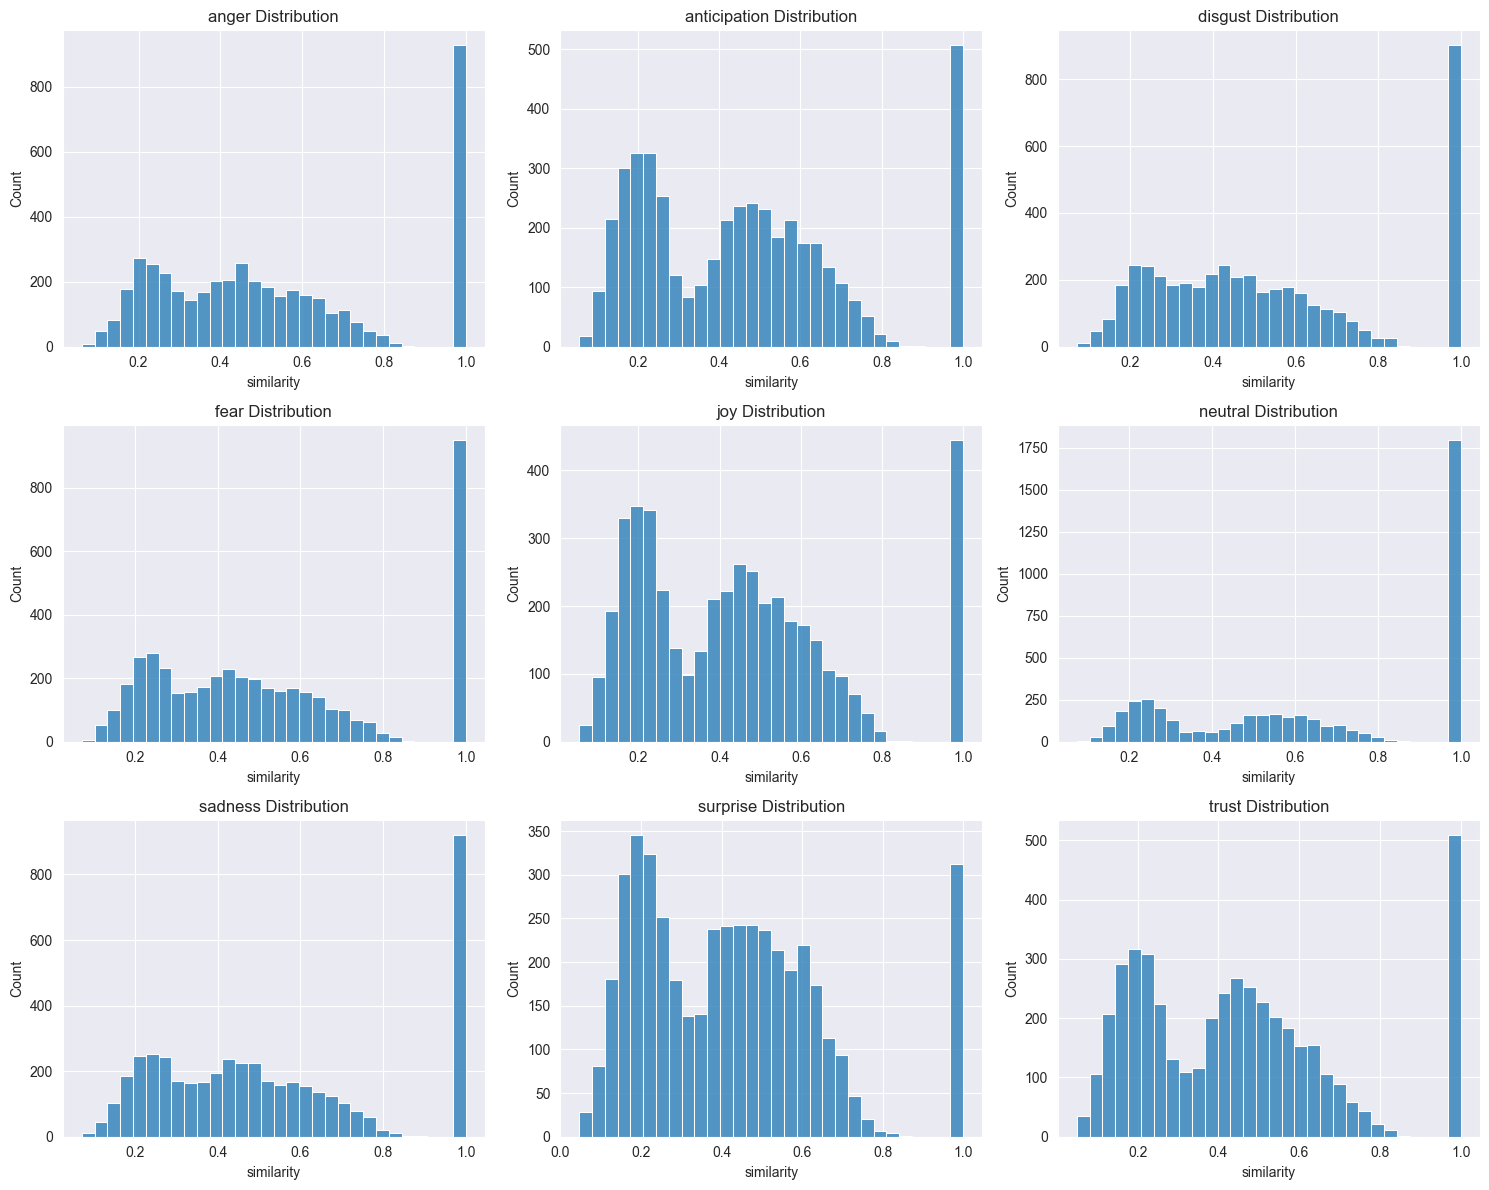

anger: mean=0.535, std=0.283
anticipation: mean=0.464, std=0.260
disgust: mean=0.536, std=0.278
fear: mean=0.538, std=0.284
joy: mean=0.444, std=0.251
sadness: mean=0.537, std=0.280
surprise: mean=0.424, std=0.232
trust: mean=0.453, std=0.260
neutral: mean=0.653, std=0.316


In [12]:
results = calculator.process_batch(list(emotion_lexicon.keys()))

# Results from EmotionDistanceCalculator
results_df = analyze_emotion_distances(results)

# Calculate statistics
stats = calculate_emotion_statistics(results_df)

# Get top matches
top_matches = get_top_matches(results_df)

# Print analysis
print_emotion_analysis(stats, top_matches)

# Create plots
figures = plot_emotion_analysis(results_df)
plt.show()

# Access specific statistics
for emotion, stat in stats.items():
    print(f"{emotion}: mean={stat['mean']:.3f}, std={stat['std']:.3f}")

In [13]:


def analyze_emotion_distances(emotion_distances_results, calculator):
    """Analysis focusing only on the closest word for each emotion."""
    all_stats = []

    for word, word_results in emotion_distances_results.items():
        cluster_info = calculator.get_cluster_info(word)

        # For each emotion, get only the closest word match
        for emotion, similarity in word_results['similarities'].items():
            if not np.isnan(similarity):  # Only include valid similarities
                stat_entry = {
                    'word': word,
                    'emotion': emotion,
                    'similarity': similarity,
                    'nearest_word': word_results['nearest_words'][emotion]
                }

                # Add cluster information if available
                if cluster_info:
                    stat_entry.update({
                        'cluster': cluster_info['cluster'],
                        'cluster_probabilities': cluster_info['probabilities']
                    })

                all_stats.append(stat_entry)

    return pd.DataFrame(all_stats)

def plot_enhanced_analysis(results_df, calculator, save_path="plots"):
    """Plot analysis of closest word similarities with consistent colors."""
    import os

    # Create save directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    figures = {}
    colors = ['#7B2CBF', '#48BFE3', '#80ED99']  # Purple, Cyan, Green

    # 1. Emotion histograms
    n_emotions = len(results_df['emotion'].unique())
    n_cols = 3
    n_rows = (n_emotions + n_cols - 1) // n_cols

    fig_hist, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for idx, emotion in enumerate(sorted(results_df['emotion'].unique())):
        emotion_data = results_df[results_df['emotion'] == emotion]

        if 'cluster' in emotion_data.columns:
            for cluster_id in range(3):
                cluster_mask = emotion_data['cluster'] == cluster_id
                cluster_similarities = emotion_data[cluster_mask]['similarity']
                if len(cluster_similarities) > 0:
                    sns.histplot(data=cluster_similarities,
                               bins=30,
                               alpha=0.6,
                               color=colors[cluster_id],  # Use consistent colors
                               label=f'Cluster {cluster_id}',
                               ax=axes[idx])
            axes[idx].legend()
        else:
            sns.histplot(data=emotion_data, x='similarity', bins=30, ax=axes[idx])

        axes[idx].set_title(f'{emotion} Distribution')
        axes[idx].set_xlabel('Similarity to Closest Word')

    # Hide empty subplots
    for idx in range(n_emotions, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    figures['emotion_histograms'] = fig_hist

    # Save emotion histograms
    fig_hist.savefig(os.path.join(save_path, 'emotion_histograms.png'),
                     dpi=300, bbox_inches='tight')

    # 2. Cluster Analysis (2x2 subplot)
    fig_clusters = plt.figure(figsize=(20, 16))
    gs = plt.GridSpec(2, 2, figure=fig_clusters)

    # 2.1 3D Cluster Visualization
    ax_3d = fig_clusters.add_subplot(gs[0, :], projection='3d')

    for cluster_id in range(3):
        mask = calculator.cluster_labels == cluster_id
        cluster_points = calculator.pca_transformed[mask]

        ax_3d.scatter(cluster_points[:, 0],
                     cluster_points[:, 1],
                     cluster_points[:, 2],
                     c=[colors[cluster_id]],  # Use consistent colors
                     label=f'Cluster {cluster_id}',
                     alpha=0.6,
                     s=10)

    centers = calculator.gmm.means_
    ax_3d.scatter(centers[:, 0],
                 centers[:, 1],
                 centers[:, 2],
                 c='black',
                 marker='*',
                 s=300,
                 label='Cluster Centers')

    ax_3d.set_xlabel(f'PC1 ({calculator.pca.explained_variance_ratio_[0]:.2%})')
    ax_3d.set_ylabel(f'PC2 ({calculator.pca.explained_variance_ratio_[1]:.2%})')
    ax_3d.set_zlabel(f'PC3 ({calculator.pca.explained_variance_ratio_[2]:.2%})')
    ax_3d.set_title('3D Emotion Clusters Visualization')
    ax_3d.legend()

    # 2.2 Normalized Emotion distribution
    ax_dist = fig_clusters.add_subplot(gs[1, 0])
    cluster_stats = calculator.get_cluster_statistics()

 # Create DataFrame for emotion distributions
    cluster_emotions = pd.DataFrame([
        {'cluster': cluster_id, 'emotion': emotion, 'count': count}
        for cluster_id, stats in cluster_stats.items()
        for emotion, count in stats['emotion_distribution'].items()
    ])

    # Get cluster sizes
    cluster_sizes = pd.DataFrame([
        {'cluster': cluster_id, 'size': stats['size']}
        for cluster_id, stats in cluster_stats.items()
    ])

    # Add cluster sizes to emotion data
    cluster_emotions = cluster_emotions.merge(cluster_sizes, on='cluster')

    # Calculate normalized proportions
    # First normalize by cluster size to get percentage within cluster
    cluster_emotions['prop_in_cluster'] = cluster_emotions['count'] / \
                                          cluster_emotions['size']

    # Then normalize by total proportion for each emotion
    emotion_totals = cluster_emotions.groupby('emotion')[
        'prop_in_cluster'].sum().reset_index()
    cluster_emotions = cluster_emotions.merge(
        emotion_totals,
        on='emotion',
        suffixes=('', '_total')
    )

    cluster_emotions['normalized_percentage'] = (
            cluster_emotions['prop_in_cluster'] /
            cluster_emotions['prop_in_cluster_total'] * 100
    )

    # Pivot the data for visualization
    pivot_data = cluster_emotions.pivot(
        index='emotion',
        columns='cluster',
        values='normalized_percentage'
    ).reset_index()

    # Plot horizontal stacked bars
    ax_dist.set_xlabel('Normalized Percentage Distribution (%)')
    ax_dist.set_ylabel('Emotion')

    bottom = np.zeros(len(pivot_data))
    for cluster in range(3):
        values = pivot_data[cluster].values
        ax_dist.barh(pivot_data['emotion'],
                     values,
                     left=bottom,
                     color=colors[cluster],
                     label=f'Cluster {cluster}')
        bottom += values

    # Add percentage labels on the bars
    for emotion_idx, emotion in enumerate(pivot_data['emotion']):
        x_pos = 0
        for cluster in range(3):
            value = pivot_data.iloc[emotion_idx][cluster]
            if value > 5:  # Only show label if percentage is greater than 5%
                x_pos += value / 2
                ax_dist.text(x_pos, emotion_idx,
                             f'{value:.1f}%',
                             ha='center',
                             va='center')
                x_pos += value / 2

    ax_dist.set_title(
        'Normalized Emotion Distribution Across Clusters\n(Accounting for Cluster Size)')
    ax_dist.legend(title='Clusters')
    ax_dist.grid(True, axis='x')
    ax_dist.set_xlim(0, 100)
    # Just ensure to use the same colors array for the barh plots

    # 2.3 Cluster sizes plot
    ax_sizes = fig_clusters.add_subplot(gs[1, 1])
    cluster_sizes = [stats['size'] for stats in cluster_stats.values()]

    size_data = pd.DataFrame({
        'Cluster': range(len(cluster_sizes)),
        'Size': cluster_sizes
    })

    # Use the same colors for the bar plot
    sns.barplot(data=size_data, x='Cluster', y='Size', ax=ax_sizes,
                palette=colors)

    # Add size labels on top of bars
    for i, v in enumerate(cluster_sizes):
        ax_sizes.text(i, v, str(v), ha='center', va='bottom')

    ax_sizes.set_title('Cluster Sizes')
    ax_sizes.set_xlabel('Cluster')
    ax_sizes.set_ylabel('Number of Words')

    # Add sample words annotation
    for i, stats in cluster_stats.items():
        sample_words = ', '.join(stats['sample_words'][:3])
        ax_sizes.text(i, 0, f'e.g., {sample_words}',
                      ha='center', va='top', rotation=45,
                      fontsize=8)


    plt.tight_layout()
    figures['cluster_analysis'] = fig_clusters

    # Save cluster analysis
    fig_clusters.savefig(os.path.join(save_path, 'cluster_analysis.png'),
                        dpi=300, bbox_inches='tight')

    return figures

Device set to use mps


Starting lexicon embedding cache...


100%|██████████| 143/143 [00:39<00:00,  3.58it/s]


Cached embeddings for 4566 words
Processing words...


100%|██████████| 4566/4566 [05:54<00:00, 12.87it/s]
/var/folders/2_/dcqzbsq91y378h2r26m31x_h0000gn/T/ipykernel_73360/4183144559.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_data, x='Cluster', y='Size', ax=ax_sizes,


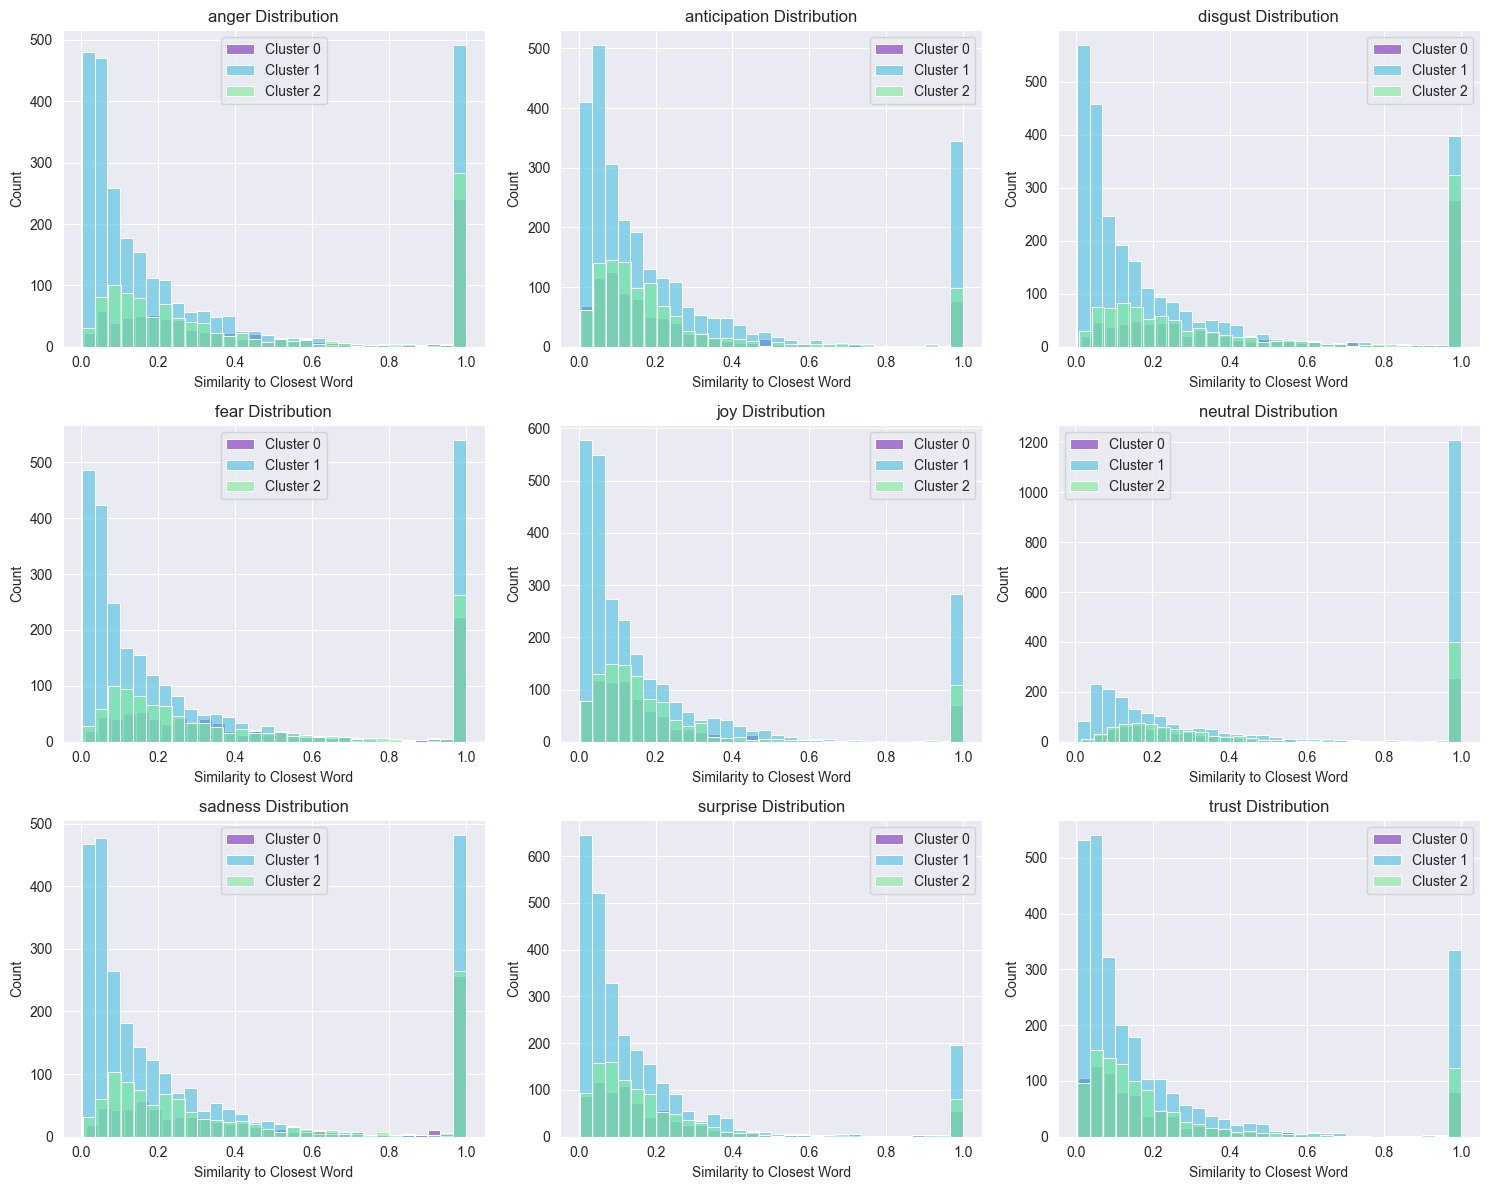

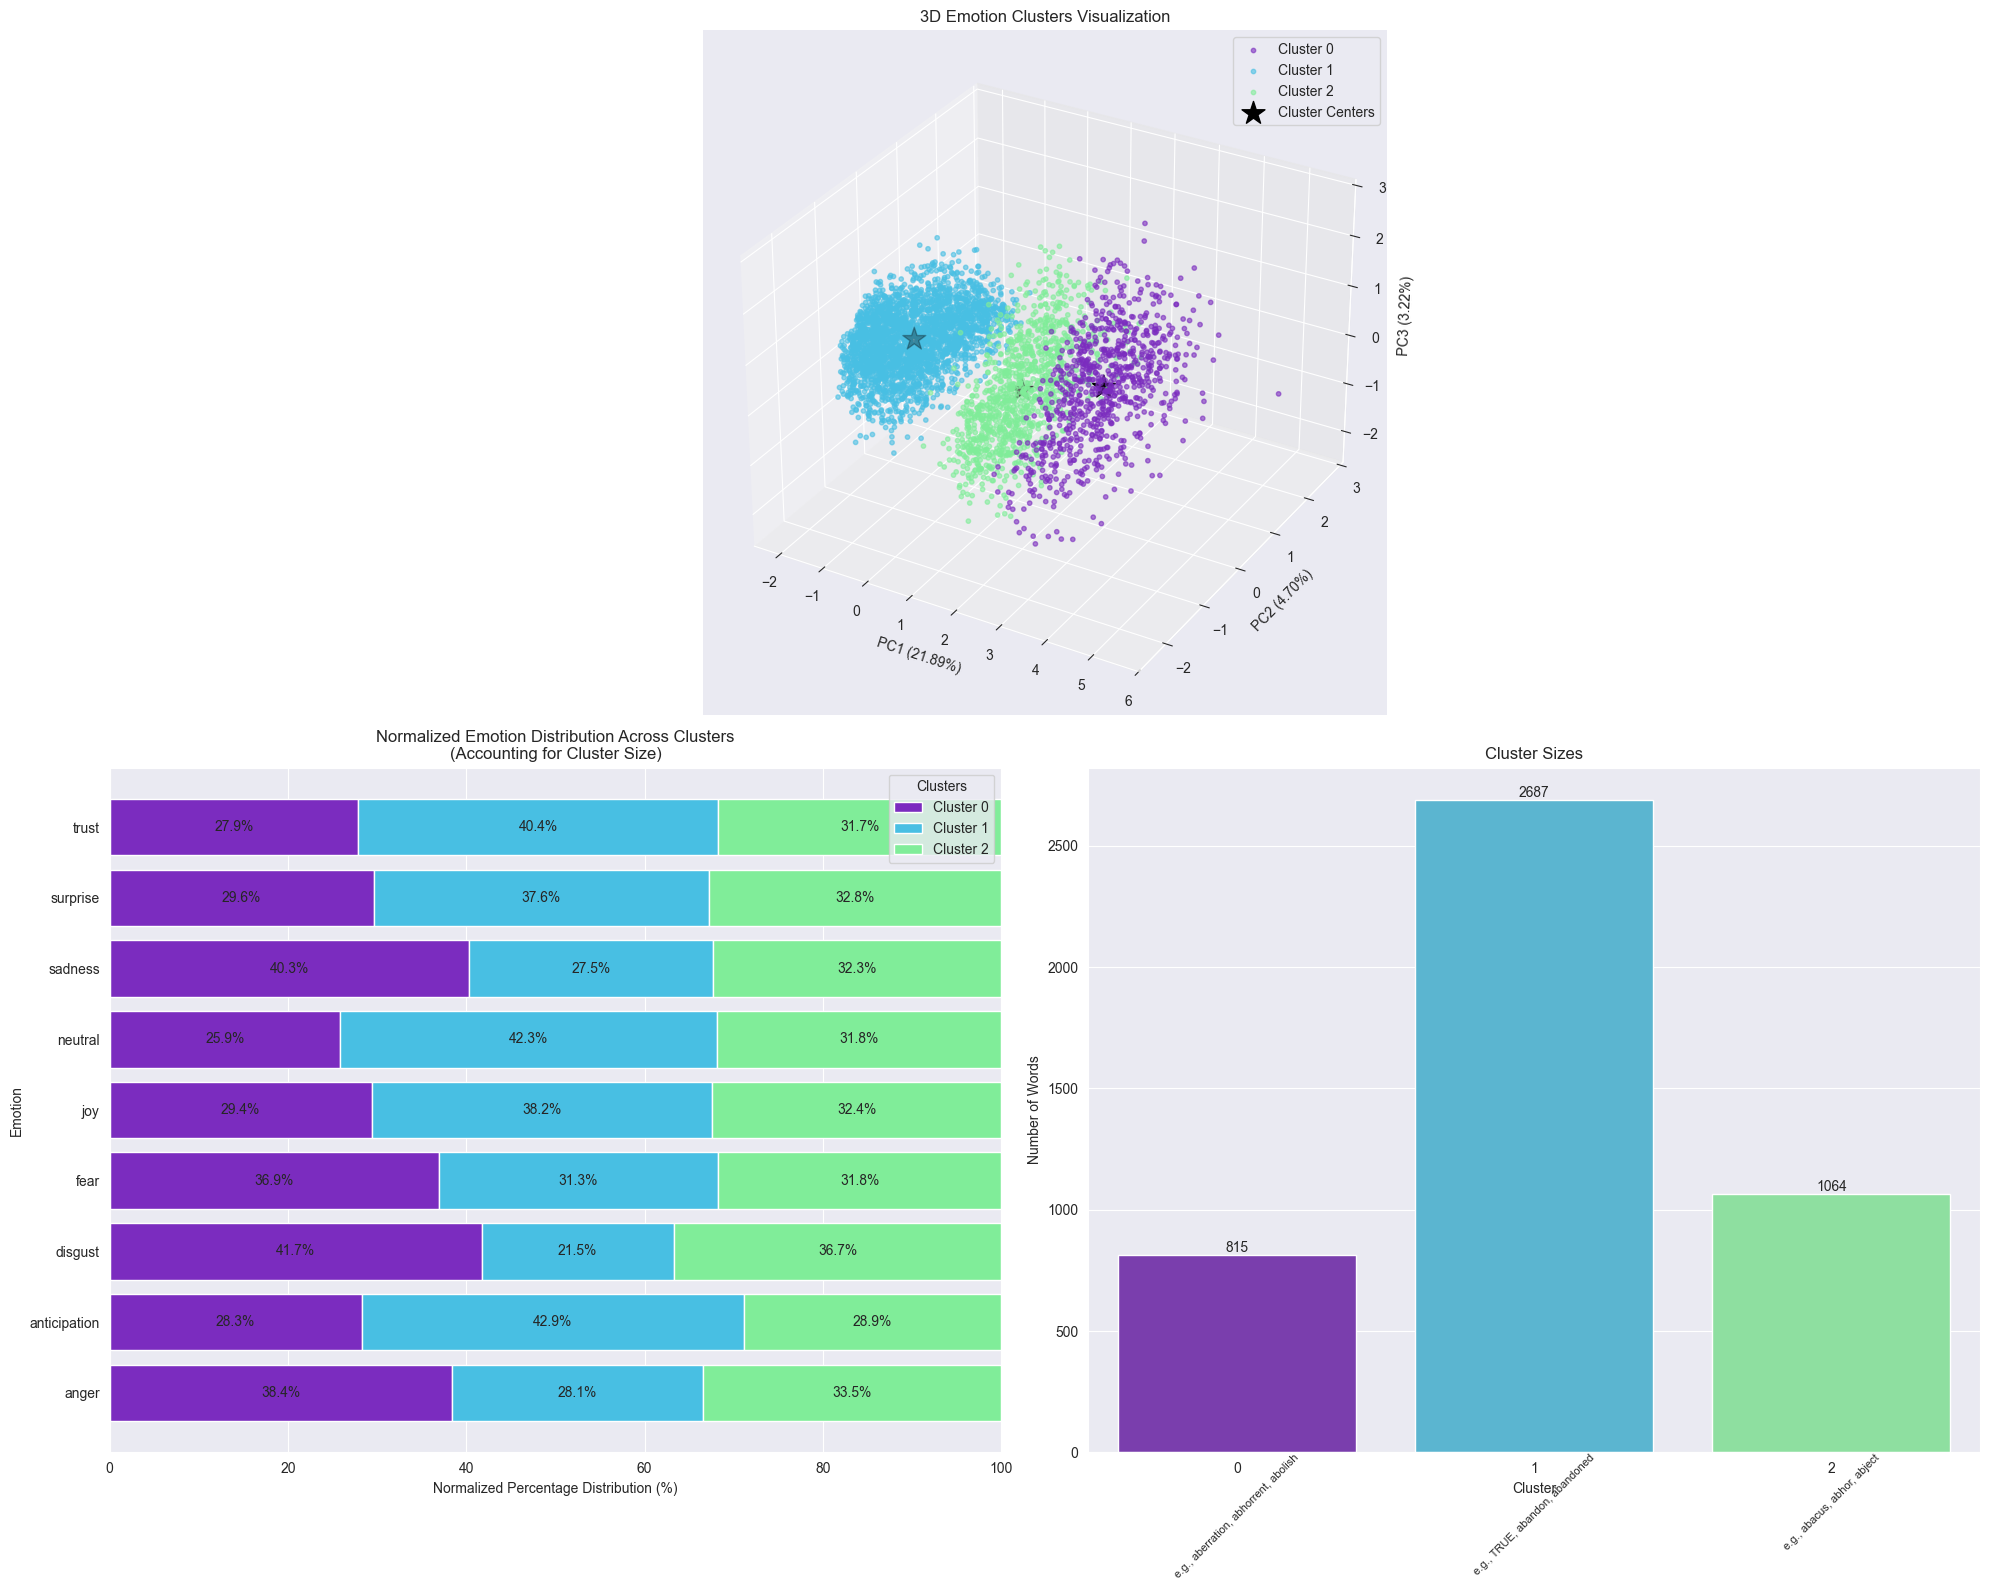


Cluster 0:
Size: 815 words
Sample words: aberration, abhorrent, abolish, abominable, abomination
Emotion distribution:
  disgust: 234
  anger: 204
  neutral: 224
  fear: 193
  sadness: 214
  trust: 70
  joy: 66
  anticipation: 69
  surprise: 47

Cluster 1:
Size: 2687 words
Sample words: TRUE, abandon, abandoned, abandonment, abbot
Emotion distribution:
  neutral: 1208
  trust: 334
  sadness: 481
  fear: 539
  surprise: 197
  disgust: 398
  anger: 491
  anticipation: 345
  joy: 283

Cluster 2:
Size: 1064 words
Sample words: abacus, abhor, abject, absentee, accurse
Emotion distribution:
  neutral: 360
  anger: 232
  disgust: 269
  fear: 217
  trust: 104
  joy: 95
  anticipation: 92
  sadness: 224
  surprise: 68


In [14]:
calculator = EmotionDistanceCalculator(emotion_lexicon,
                                       batch_size=32,
                                       use_clusters=True)

results = calculator.process_batch(list(emotion_lexicon.keys()))

# Analyze results with cluster information
df = analyze_emotion_distances(results, calculator)

# Create enhanced visualizations
figures = plot_enhanced_analysis(df, calculator)
plt.show()

# Print cluster statistics
cluster_stats = calculator.get_cluster_statistics()
for cluster_id, stats in cluster_stats.items():
    print(f"\nCluster {cluster_id}:")
    print(f"Size: {stats['size']} words")
    print(f"Sample words: {', '.join(stats['sample_words'])}")
    print("Emotion distribution:")
    for emotion, count in stats['emotion_distribution'].items():
        print(f"  {emotion}: {count}")


Word Length Statistics by Cluster:

Cluster 0:
Mean length: 9.53
Median length: 9.00
Std dev: 2.01
Min length: 4
Max length: 17

Sample words by length:
Shortest: glut, bloat, evict, exalt, usurp
Longest: disillusionment, inconsequential, reconsideration, unintentionally, misrepresentation

Cluster 1:
Mean length: 7.13
Median length: 7.00
Std dev: 2.34
Min length: 3
Max length: 16

Sample words by length:
Shortest: air, arm, art, ash, bad
Longest: reconciliation, reconstruction, rehabilitation, straightforward, misunderstanding

Cluster 2:
Mean length: 7.10
Median length: 7.00
Std dev: 2.13
Min length: 3
Max length: 14

Sample words by length:
Shortest: aga, ail, alb, asp, coy
Longest: astonishingly, mortification, confidentially, impressionable, slaughterhouse


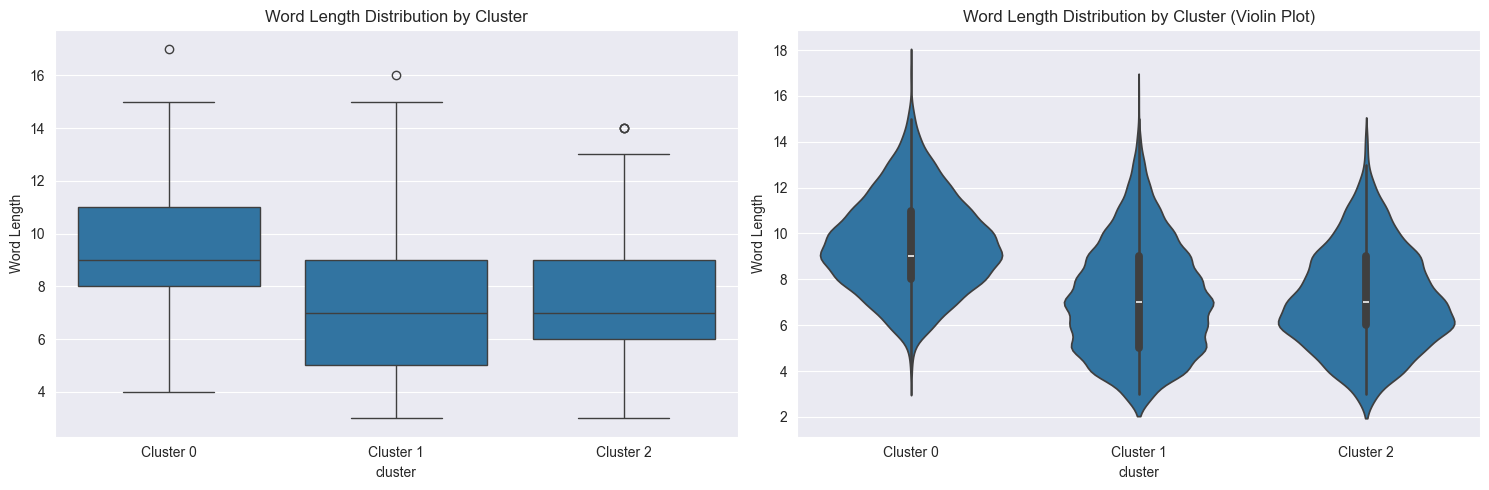

In [15]:
def analyze_word_lengths(calculator):
    """Analyze word lengths distribution across clusters."""
    # Collect word lengths for each cluster
    cluster_lengths = {i: [] for i in range(3)}

    for word, info in calculator.word_clusters.items():
        cluster = info['cluster']
        length = len(word)
        cluster_lengths[cluster].append(length)

    # Create DataFrame for visualization
    data = []
    for cluster, lengths in cluster_lengths.items():
        for length in lengths:
            data.append({
                'cluster': f'Cluster {cluster}',
                'length': length
            })
    df = pd.DataFrame(data)

    # Plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Box plot
    sns.boxplot(data=df, x='cluster', y='length', ax=ax1)
    ax1.set_title('Word Length Distribution by Cluster')
    ax1.set_ylabel('Word Length')

    # Violin plot with individual points
    sns.violinplot(data=df, x='cluster', y='length', ax=ax2)
    ax2.set_title('Word Length Distribution by Cluster (Violin Plot)')
    ax2.set_ylabel('Word Length')

    plt.tight_layout()

    # Print statistics
    print("\nWord Length Statistics by Cluster:")
    for cluster in range(3):
        lengths = cluster_lengths[cluster]
        print(f"\nCluster {cluster}:")
        print(f"Mean length: {np.mean(lengths):.2f}")
        print(f"Median length: {np.median(lengths):.2f}")
        print(f"Std dev: {np.std(lengths):.2f}")
        print(f"Min length: {min(lengths)}")
        print(f"Max length: {max(lengths)}")

        # Print some sample words of different lengths
        print("\nSample words by length:")
        words = [(word, len(word)) for word, info in calculator.word_clusters.items()
                if info['cluster'] == cluster]
        words.sort(key=lambda x: x[1])
        print("Shortest:", ", ".join(word for word, length in words[:5]))
        print("Longest:", ", ".join(word for word, length in words[-5:]))

    return df

length_analysis = analyze_word_lengths(calculator)
plt.show()

In [16]:

def plot_emotion_vector_analysis(results_df):
    """
    Create histogram plots for emotion vector similarities.

    Args:
        results_df: DataFrame from analyze_emotion_distances with emotion_similarities

    Returns:
        Dictionary of figures
    """
    figures = {}

    # Histogram grid for each emotion
    n_emotions = len(results_df['emotion'].unique())
    n_cols = 3
    n_rows = (n_emotions + n_cols - 1) // n_cols

    fig_hist, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for idx, emotion in enumerate(sorted(results_df['emotion'].unique())):
        emotion_data = results_df[results_df['emotion'] == emotion]
        sns.histplot(data=emotion_data, x='emotion_similarity', bins=30,
                     ax=axes[idx])
        axes[idx].set_title(f'{emotion} Vector Similarity Distribution')
        axes[idx].set_xlabel('Emotion Vector Similarity')
        axes[idx].set_ylabel('Count')

    # Hide empty subplots
    for idx in range(n_emotions, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    figures['histograms'] = fig_hist

    return figures


def analyze_emotion_distances_with_vectors(emotion_distances_results):
    """
    Extended version of analyze_emotion_distances that includes vector similarities.
    """
    all_stats = []

    for word, word_results in emotion_distances_results.items():
        for emotion, similarity in word_results['similarities'].items():
            if not np.isnan(similarity):
                all_stats.append({
                    'word'              : word,
                    'emotion'           : emotion,
                    'similarity'        : similarity,
                    'emotion_similarity': word_results['emotion_similarities'][
                        emotion],
                    'nearest_word'      : word_results['nearest_words'][
                        emotion]
                })

    return pd.DataFrame(all_stats)

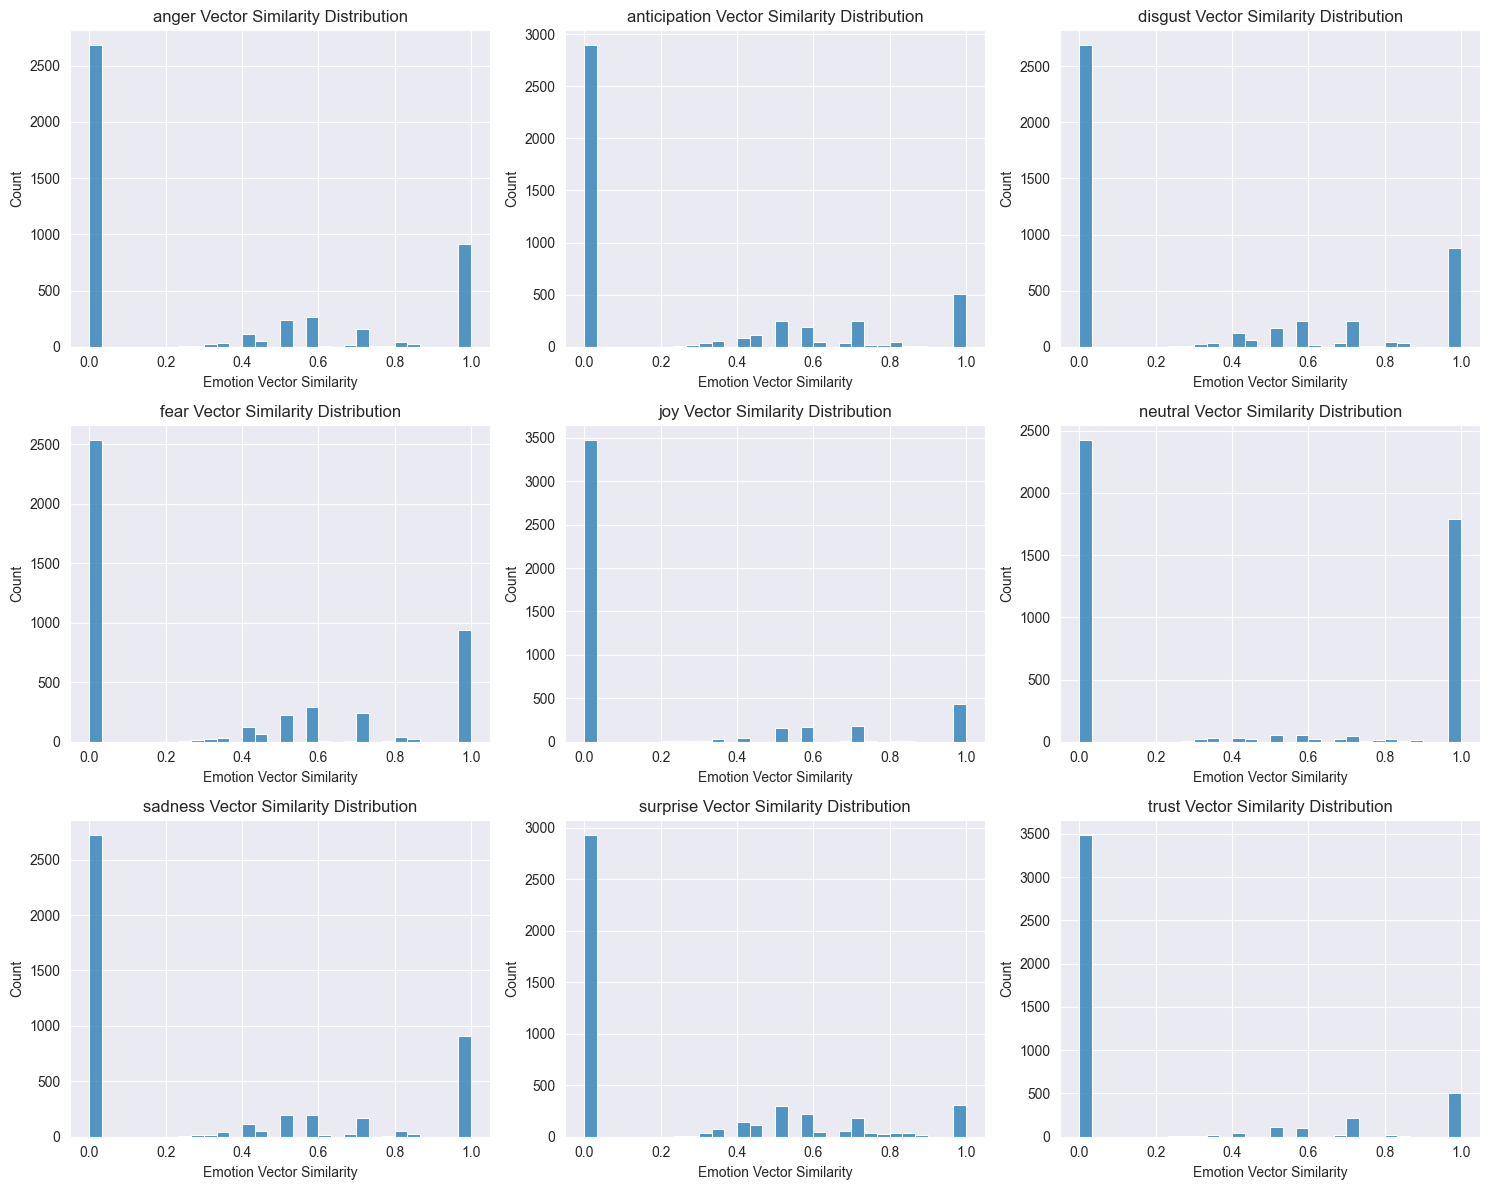

In [17]:
results_df_new = analyze_emotion_distances_with_vectors(results)

# Create plots
figures = plot_emotion_vector_analysis(results_df_new)
plt.show()

In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import hamming
from scipy.stats import entropy

def create_emotion_vector(emotions, all_emotions):
    """Create binary emotion vector."""
    vector = np.zeros(len(all_emotions))
    for emotion in emotions:
        if emotion in all_emotions:
            idx = all_emotions.index(emotion)
            vector[idx] = 1
    return vector

def calculate_vector_diversity(emotion_vectors):
    """Calculate diversity metrics for a set of emotion vectors."""
    vectors = np.array(list(emotion_vectors))

    # Count unique vectors and get their counts
    unique_vectors_tuples = [tuple(v) for v in vectors]
    unique_vectors_set = set(unique_vectors_tuples)
    vector_counts = {v: unique_vectors_tuples.count(v) for v in unique_vectors_set}
    unique_vectors = float(len(unique_vectors_set))  # Convert to float

    # Calculate average Hamming distance between unique vectors
    unique_vectors_array = np.array([np.array(v) for v in unique_vectors_set])
    n_unique = len(unique_vectors_array)

    if n_unique > 1:
        distances = []
        for i in range(n_unique):
            for j in range(i + 1, n_unique):
                dist = np.sum(unique_vectors_array[i] != unique_vectors_array[j]) / len(unique_vectors_array[i])
                distances.append(dist)

        distances = np.array(distances)
        avg_hamming = float(np.mean(distances))  # Convert to float

        # Calculate entropy for each emotion dimension
        entropies = []
        for dim in range(vectors.shape[1]):
            values, counts = np.unique(vectors[:, dim], return_counts=True)
            probs = counts / len(vectors)
            entropies.append(float(entropy(probs, base=2)))  # Convert to float
        avg_entropy = float(np.mean(entropies))  # Convert to float

        # Print statistics for debugging
        print(f"\nVector diversity at {n_unique} unique patterns:")
        print(f"Average Hamming distance: {avg_hamming:.3f}")
        print(f"Average entropy: {avg_entropy:.3f}")

    else:
        avg_hamming = 0.0
        avg_entropy = 0.0
        entropies = [0.0] * vectors.shape[1]

    return {
        'unique_vectors': unique_vectors,
        'avg_hamming_distance': avg_hamming,
        'avg_entropy': avg_entropy,
        'dimension_entropies': entropies
    }

def analyze_potential_expansions(results, emotion_lexicon, thresholds):
    """Analyze how the lexicon would expand at different similarity thresholds."""
    expansion_stats = []
    all_emotions = list(next(iter(results.values()))['similarities'].keys())

    for threshold in tqdm(thresholds, desc="Analyzing thresholds"):
        new_assignments = 0
        new_words = set()
        emotion_expansions = {emotion: 0 for emotion in all_emotions}
        expanded_vectors = []

        for word, word_data in results.items():
            current_emotions = set(emotion_lexicon.get(word, []))
            new_emotions = set()

            for emotion, sim in word_data['similarities'].items():
                if not np.isnan(sim) and sim >= threshold and emotion not in current_emotions:
                    new_assignments += 1
                    new_words.add(word)
                    emotion_expansions[emotion] += 1
                    new_emotions.add(emotion)

            if new_emotions:
                combined_emotions = current_emotions.union(new_emotions)
                vector = create_emotion_vector(combined_emotions, all_emotions)
                expanded_vectors.append(vector)

        if expanded_vectors:
            diversity_metrics = calculate_vector_diversity(expanded_vectors)
        else:
            diversity_metrics = {
                'unique_vectors': 0.0,
                'avg_hamming_distance': 0.0,
                'avg_entropy': 0.0,
                'dimension_entropies': [0.0] * len(all_emotions)
            }

        stats = {
            'threshold': threshold,
            'new_assignments': float(new_assignments),
            'unique_words_expanded': float(len(new_words)),
            'avg_new_emotions_per_word': float(new_assignments) / len(new_words) if len(new_words) > 0 else 0.0,
            'unique_emotion_vectors': diversity_metrics['unique_vectors'],
            'avg_hamming_distance': diversity_metrics['avg_hamming_distance'],
            'avg_entropy': diversity_metrics['avg_entropy']
        }

        # Add emotion-specific expansions
        for emotion, count in emotion_expansions.items():
            stats[f'{emotion}_expansions'] = float(count)

        # Add dimension-specific entropies
        for i, entropy_val in enumerate(diversity_metrics['dimension_entropies']):
            stats[f'{all_emotions[i]}_entropy'] = float(entropy_val)

        expansion_stats.append(stats)

    return pd.DataFrame(expansion_stats)

def plot_expansion_analysis(expansion_df):
    """Create visualizations of the expansion analysis."""
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 15))
    gs = plt.GridSpec(3, 2, figure=fig)

    # Plot 1: Total expansions
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(expansion_df['threshold'], expansion_df['new_assignments'],
                label='Total New Assignments', marker='o', base=10)
    ax1.semilogy(expansion_df['threshold'], expansion_df['unique_words_expanded'],
                label='Unique Words Expanded', marker='o', base=10)
    ax1.set_xlabel('Similarity Threshold')
    ax1.set_ylabel('Count (log scale)')
    ax1.set_title('Lexicon Expansion Overview')
    ax1.legend()
    ax1.grid(True, which="both", ls="-")

    # Plot 2: Emotion-specific expansions
    ax2 = fig.add_subplot(gs[0, 1])
    emotion_columns = [col for col in expansion_df.columns if col.endswith('_expansions')]
    for col in emotion_columns:
        emotion = col.replace('_expansions', '')
        ax2.semilogy(expansion_df['threshold'], expansion_df[col],
                   label=emotion, marker='o', base=10)
    ax2.set_xlabel('Similarity Threshold')
    ax2.set_ylabel('Number of New Assignments (log scale)')
    ax2.set_title('Emotion-Specific Expansions')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, which="both", ls="-")

    # Plot 3: Diversity metrics
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(expansion_df['threshold'], expansion_df['unique_emotion_vectors'],
            label='Number of Unique Patterns', marker='o', color='blue')
    ax3_twin = ax3.twinx()
    ax3_twin.plot(expansion_df['threshold'], expansion_df['avg_hamming_distance'],
                 label='Avg Pattern Distance', marker='o', color='red')
    ax3.set_xlabel('Similarity Threshold')
    ax3.set_ylabel('Number of Unique Patterns', color='blue')
    ax3_twin.set_ylabel('Average Pattern Distance', color='red')
    ax3.set_title('Emotion Pattern Diversity')
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax3.grid(True)

    # Plot 4: Emotion-specific entropy
    ax4 = fig.add_subplot(gs[2, :])
    entropy_columns = [col for col in expansion_df.columns if col.endswith('_entropy')]
    for col in entropy_columns:
        emotion = col.replace('_entropy', '')
        ax4.plot(expansion_df['threshold'], expansion_df[col],
                label=emotion, marker='o')
    ax4.set_xlabel('Similarity Threshold')
    ax4.set_ylabel('Entropy')
    ax4.set_title('Emotion-Specific Entropy')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True)

    plt.tight_layout()
    return fig

Analyzing thresholds:  11%|█         | 2/19 [00:00<00:01,  9.16it/s]


Vector diversity at 211 unique patterns:
Average Hamming distance: 0.483
Average entropy: 0.553

Vector diversity at 258 unique patterns:
Average Hamming distance: 0.494
Average entropy: 0.740


Analyzing thresholds:  21%|██        | 4/19 [00:00<00:01,  8.44it/s]


Vector diversity at 304 unique patterns:
Average Hamming distance: 0.496
Average entropy: 0.835

Vector diversity at 304 unique patterns:
Average Hamming distance: 0.497
Average entropy: 0.890


Analyzing thresholds:  32%|███▏      | 6/19 [00:00<00:01,  8.71it/s]


Vector diversity at 306 unique patterns:
Average Hamming distance: 0.497
Average entropy: 0.907

Vector diversity at 296 unique patterns:
Average Hamming distance: 0.498
Average entropy: 0.911


Analyzing thresholds:  47%|████▋     | 9/19 [00:00<00:00, 10.82it/s]


Vector diversity at 283 unique patterns:
Average Hamming distance: 0.496
Average entropy: 0.902

Vector diversity at 249 unique patterns:
Average Hamming distance: 0.494
Average entropy: 0.890

Vector diversity at 214 unique patterns:
Average Hamming distance: 0.492
Average entropy: 0.886

Vector diversity at 192 unique patterns:
Average Hamming distance: 0.488
Average entropy: 0.865


Analyzing thresholds:  74%|███████▎  | 14/19 [00:01<00:00, 17.49it/s]


Vector diversity at 182 unique patterns:
Average Hamming distance: 0.485
Average entropy: 0.857

Vector diversity at 159 unique patterns:
Average Hamming distance: 0.477
Average entropy: 0.845

Vector diversity at 142 unique patterns:
Average Hamming distance: 0.469
Average entropy: 0.831

Vector diversity at 126 unique patterns:
Average Hamming distance: 0.463
Average entropy: 0.826

Vector diversity at 114 unique patterns:
Average Hamming distance: 0.458
Average entropy: 0.815

Vector diversity at 102 unique patterns:
Average Hamming distance: 0.455
Average entropy: 0.816

Vector diversity at 94 unique patterns:
Average Hamming distance: 0.448
Average entropy: 0.813


Analyzing thresholds: 100%|██████████| 19/19 [00:01<00:00, 14.78it/s]



Vector diversity at 87 unique patterns:
Average Hamming distance: 0.448
Average entropy: 0.808

Vector diversity at 76 unique patterns:
Average Hamming distance: 0.444
Average entropy: 0.792


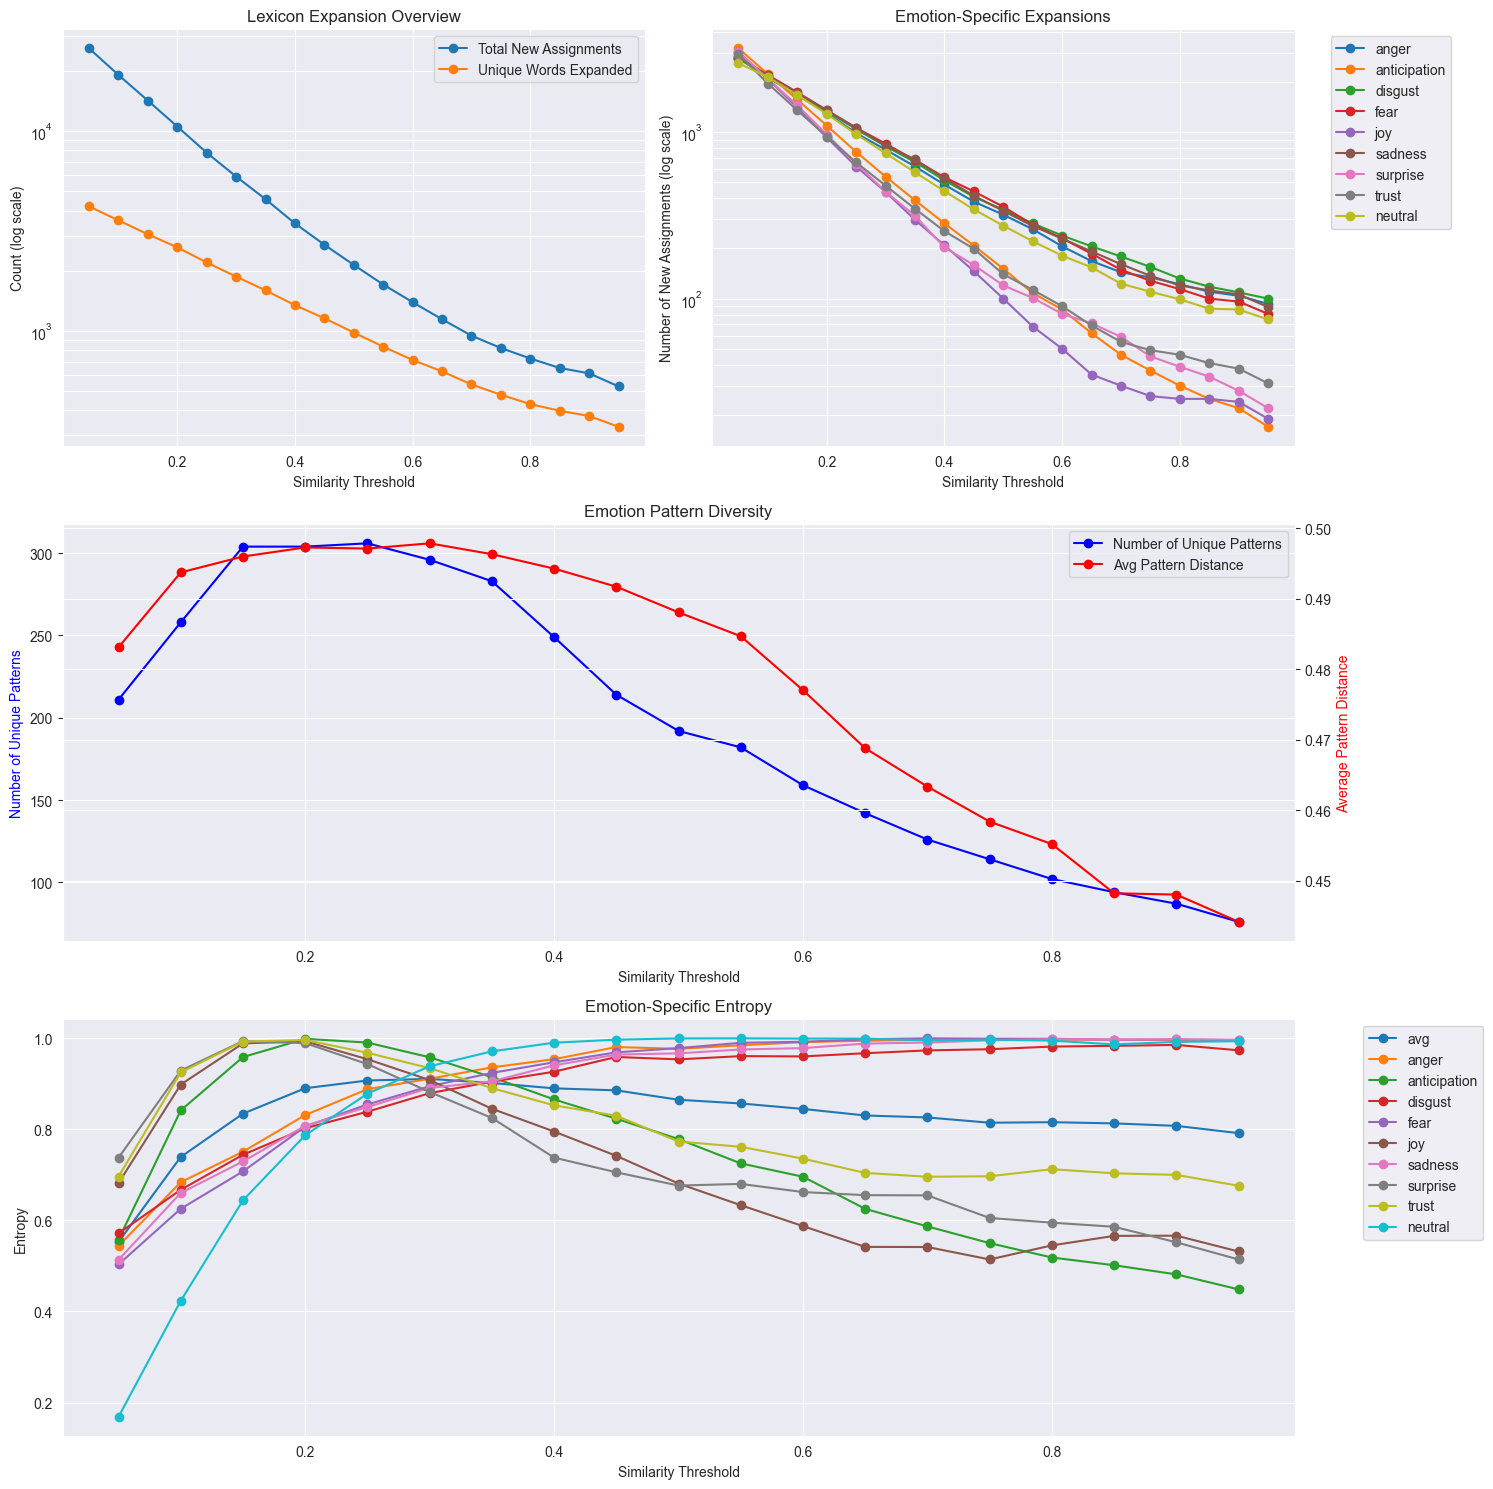

In [53]:
# Test with a range of thresholds
thresholds = np.arange(0.05, 1.0, 0.05)
expansion_df = analyze_potential_expansions(results, emotion_lexicon, thresholds)

# Plot the results
fig = plot_expansion_analysis(expansion_df)
plt.show()